# Malware Detection Using Network Traffic Data

## Introduction

In the world of cybersecurity, detecting malware in network traffic data is critical to ensure the security and integrity of systems. Artificial Intelligence (AI), especially Machine Learning (ML) techniques, can be used to detect malicious activities in network traffic. 

This notebook will walk through a practical example of how AI can be used for malware detection using network traffic data. We will generate a synthetic dataset that simulates benign and malicious network traffic. Afterward, we will perform a deep exploratory data analysis (EDA) and use a classification model to detect malware.

## Problem Statement

The goal is to classify network traffic data as either benign or malicious based on features derived from network behavior.


## Generating Fake Dataset with Mathematical Relationship for Malicious Traffic

In this section, we will generate a synthetic dataset where the `is_malicious` label is determined by a mathematical combination of various features. A score will be computed for each network traffic record based on a weighted sum of features such as `packets`, `data_size`, `src_ip_entropy`, and more. If the score exceeds a certain threshold, the traffic will be classified as malicious.


In [2]:
! pip install seaborn matplotlib pandas numpy scikit-learn tensorflow --quiet


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

df = pd.read_csv(r"data\malware_detection_dataset.csv")
# Display the first few rows of the dataset
df.head()


,Unnamed: 0,packets,data_size,duration,protocol_type,src_ip_entropy,dst_ip_entropy,src_port,dst_port,is_malicious,PCA1,PCA2
0,0,549,23925,46.636386,0,0.562393,0.542418,25035,33550,0,-0.310050,-0.700448
1,1,486,11111,46.837479,2,0.409978,0.580064,62894,19715,0,-0.060427,1.127247
2,2,564,23573,83.531412,1,0.448570,0.471148,42483,50710,0,-0.839648,0.896977
3,3,652,18831,62.139664,0,0.554119,0.514444,13085,15047,0,-0.674629,-1.765020
4,4,476,23537,87.209764,1,0.475231,0.553307,56395,42063,0,-0.837133,1.187784


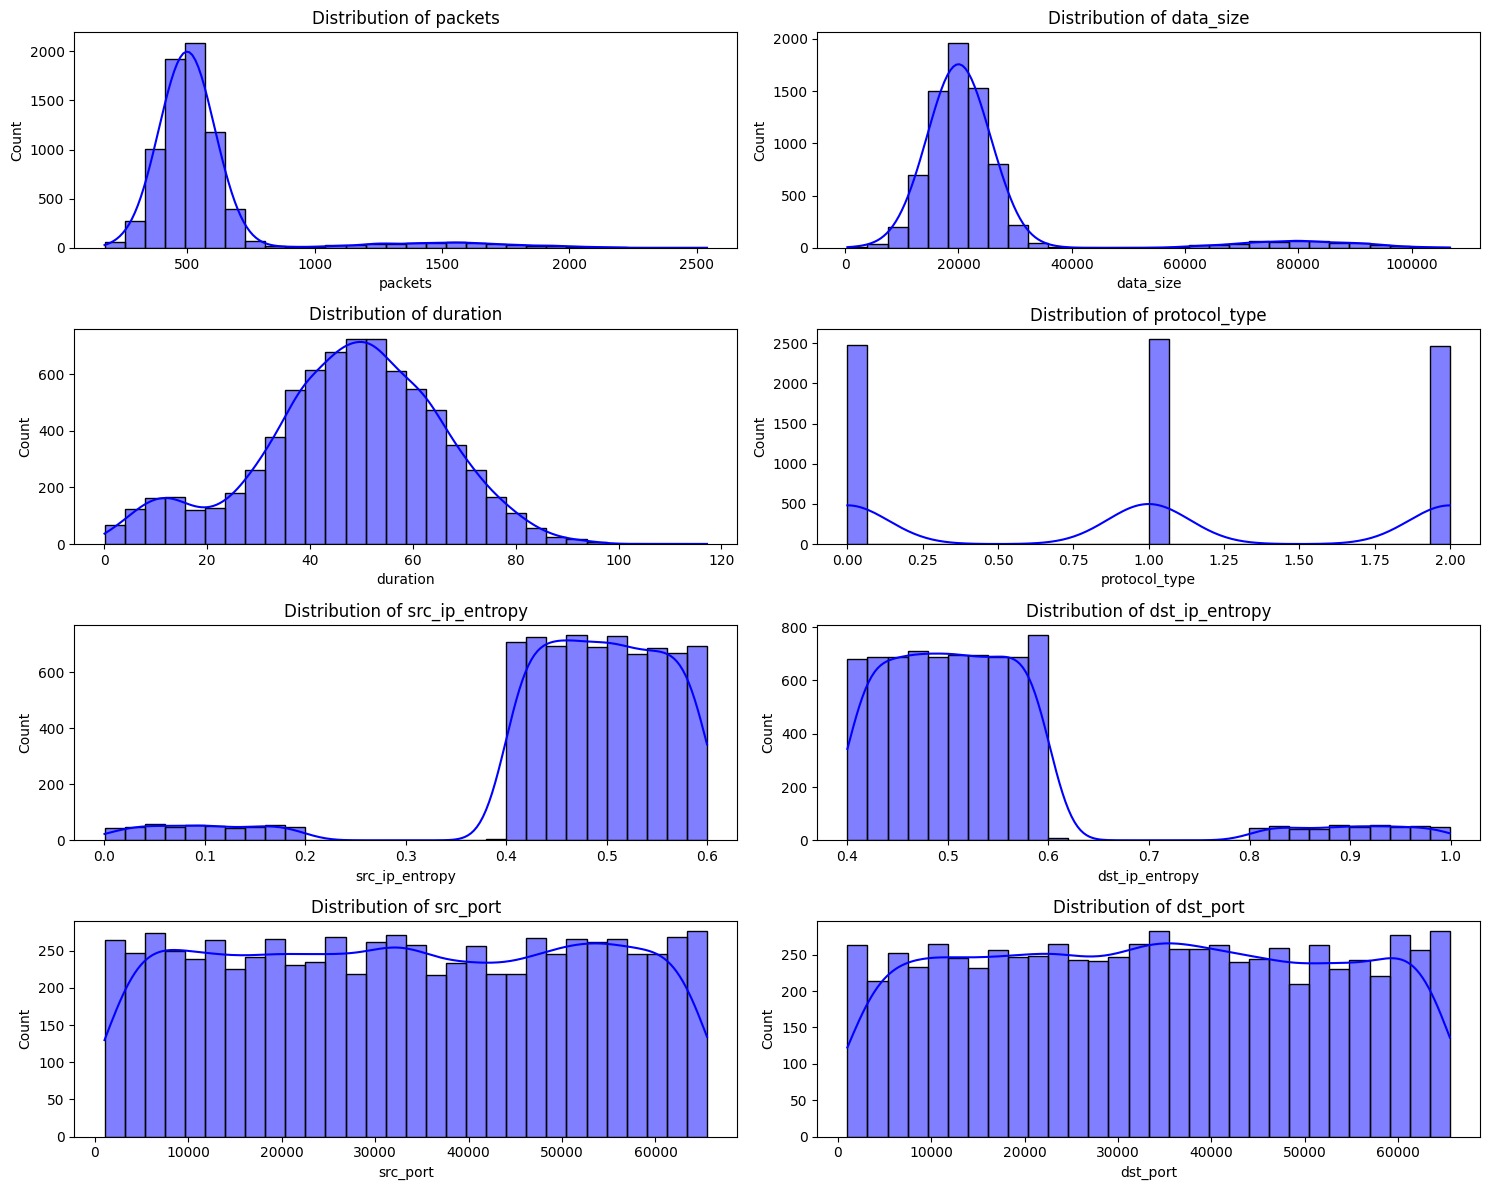

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(15, 12))

# Loop through each feature and plot the distribution
features = ['packets', 'data_size', 'duration', 'protocol_type', 'src_ip_entropy', 'dst_ip_entropy', 'src_port', 'dst_port']
for i, feature in enumerate(features, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[feature], kde=True, bins=30, color='blue' )
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()


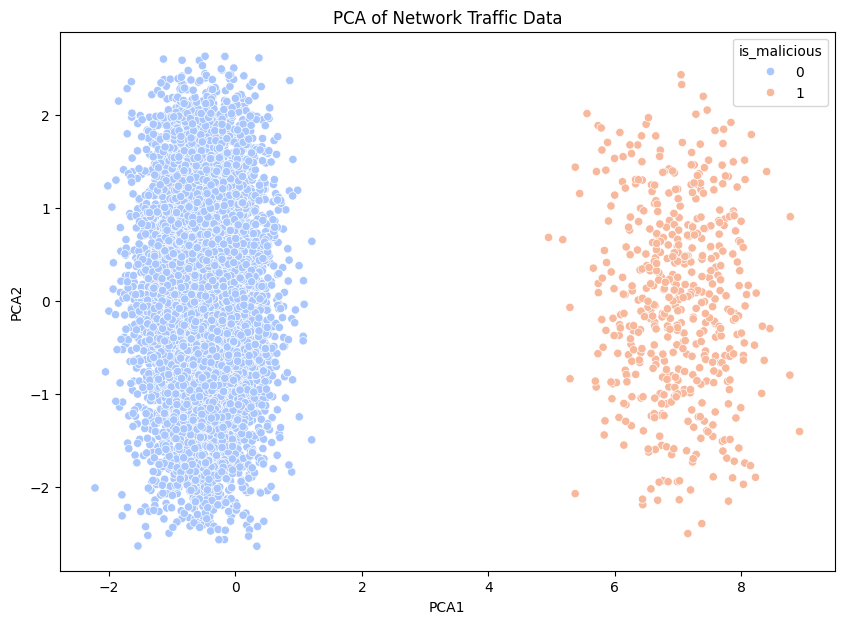

Explained variance by PCA1: 0.47
Explained variance by PCA2: 0.13


In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Select only the numeric columns (excluding 'is_malicious' since it's the target)
features = ['packets', 'data_size', 'duration', 'protocol_type', 'src_ip_entropy', 'dst_ip_entropy', 'src_port', 'dst_port']

# Scale the features to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Perform PCA
pca = PCA(n_components=2)  # Reduce the data to 2 dimensions for visualization
X_pca = pca.fit_transform(X_scaled)

# Add the PCA components back to the dataframe for visualization
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Visualize the PCA result in a scatter plot, coloring by 'is_malicious'
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', hue='is_malicious', palette='coolwarm', data=df)
plt.title('PCA of Network Traffic Data')
plt.show()

# Explained variance of each PCA component
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by PCA1: {explained_variance[0]:.2f}')
print(f'Explained variance by PCA2: {explained_variance[1]:.2f}')


## Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is crucial for understanding the structure of the dataset and finding any patterns, outliers, or correlations in the data. Let's explore our dataset in detail.


In [18]:
df.columns

Index(['Unnamed: 0', 'packets', 'data_size', 'duration', 'protocol_type',
       'src_ip_entropy', 'dst_ip_entropy', 'src_port', 'dst_port',
       'is_malicious', 'PCA1', 'PCA2'],
      dtype='object')

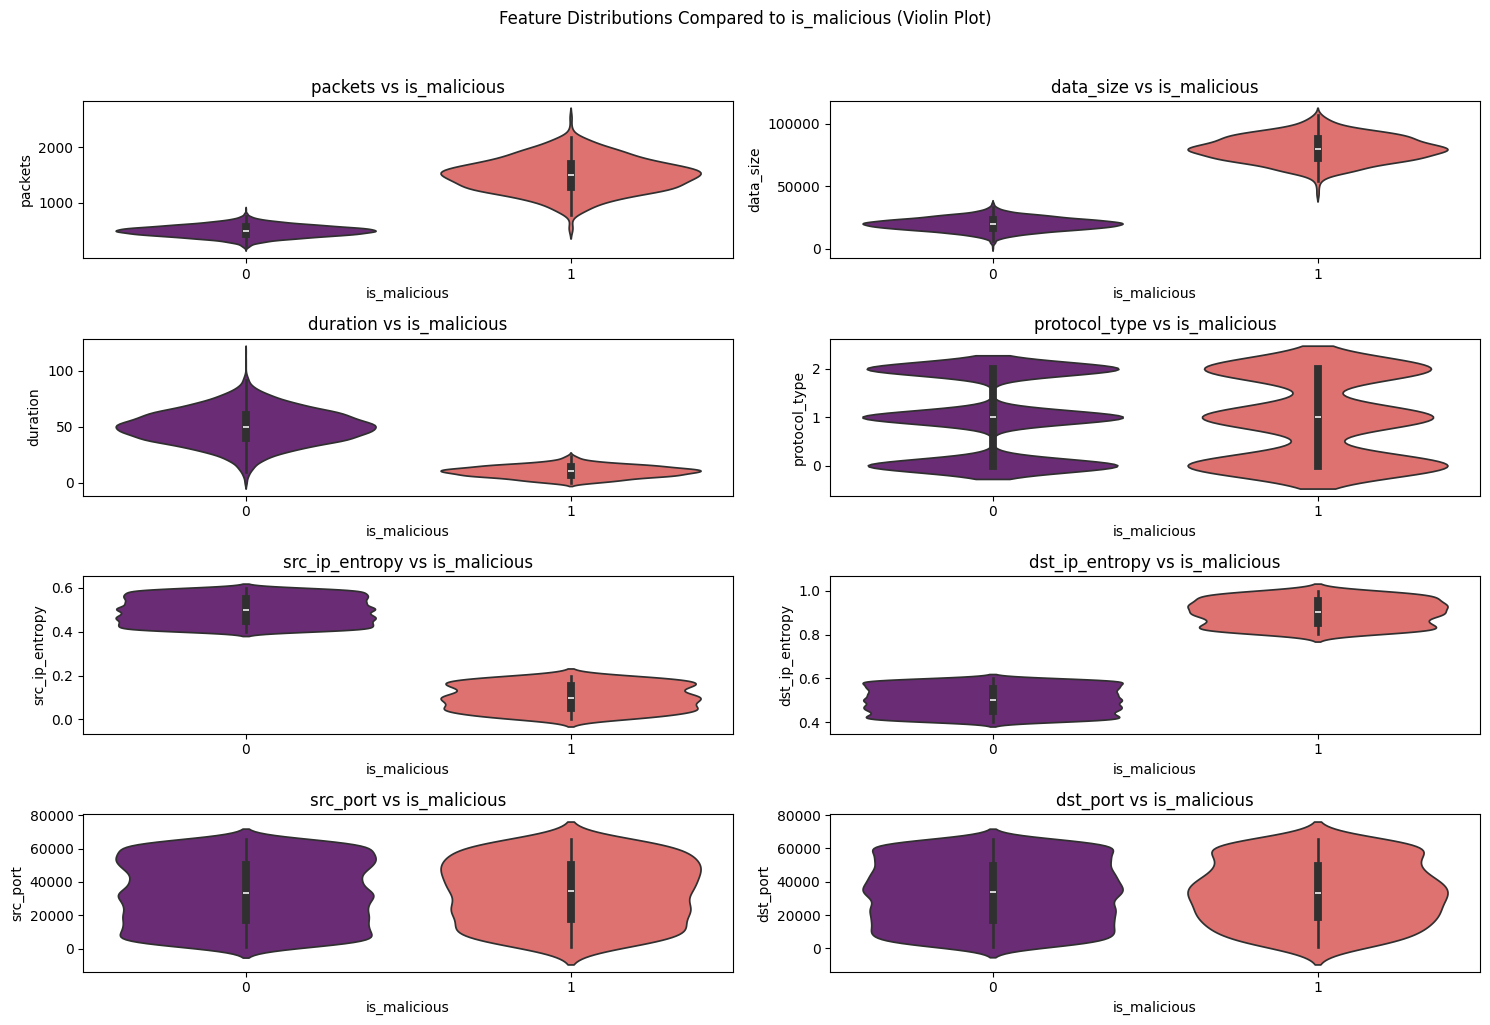

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size for all subplots
plt.figure(figsize=(15, 10))

# Define the features to plot
features = ['packets', 'data_size', 'duration', 'protocol_type', 'src_ip_entropy', 'dst_ip_entropy', 'src_port', 'dst_port']

# Loop over each feature and create a violin plot with the 'magma' palette
for i, feature in enumerate(features, 1):
    plt.subplot(4, 2, i)  # Create a 4x2 grid for subplots
    sns.violinplot(x='is_malicious', y=feature, data=df, hue='is_malicious', palette="magma", legend=False)
    plt.title(f'{feature} vs is_malicious')

# Add a title for the whole figure
plt.suptitle('Feature Distributions Compared to is_malicious (Violin Plot)', y=1.02)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


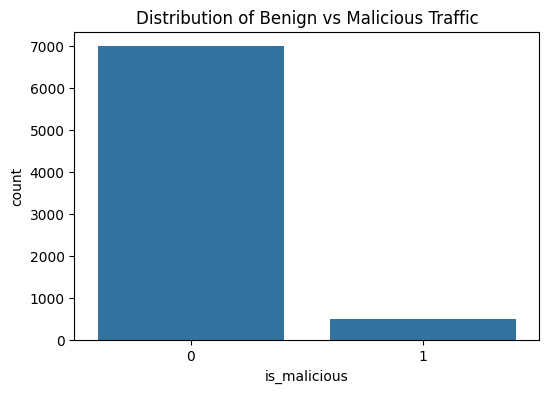

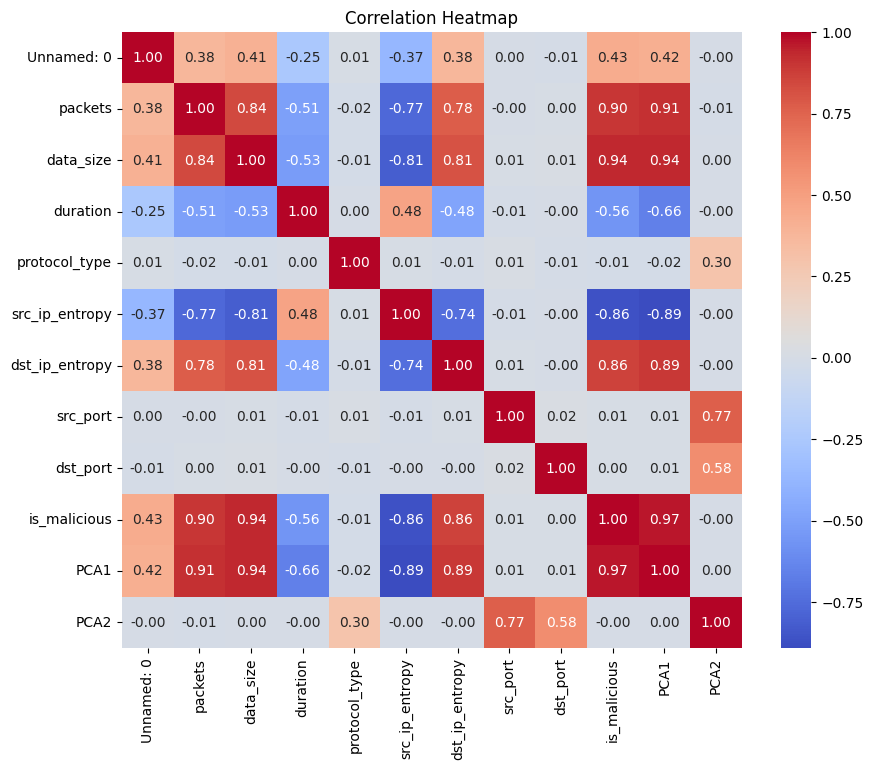

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


# Visualize the distribution of benign vs malicious traffic
plt.figure(figsize=(6, 4))
sns.countplot(x='is_malicious', data=df)
plt.title('Distribution of Benign vs Malicious Traffic')
plt.show()


# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


## Preprocessing the Data

Before building the model, we need to preprocess the dataset. We will scale the numerical features, handle categorical variables, and split the data into training and testing sets.


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features and target variable
X = df.drop('is_malicious', axis=1)
y = df['is_malicious']

# Scaling numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Check the shape of the training and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((6000, 11), (1500, 11), (6000,), (1500,))

### Logistic Regression

Logistic Regression is a commonly used binary classification model. We'll train and evaluate it to detect malware in network traffic.
In this cell, I am training and evaluating a **Logistic Regression model** on a dataset, using `scikit-learn`.

![Alt Text](https://images.spiceworks.com/wp-content/uploads/2022/04/11040521/46-4-e1715636469361.png)

### 1. Model Training:
We initialize the logistic regression model:

$
\hat{y} = \sigma(w^T x + b)
$

Where:
- $\hat{y}$ is the predicted probability of the class label being 1.
- $\sigma(z)$ is the sigmoid function: $\sigma(z) = \frac{1}{1 + e^{-z}}$.
- $w^T x$ is the dot product of the weight vector $w$ and input features $x$.
- $b$ is the bias term.

The model learns the parameters $w$ and $b$ through optimization, using **Maximum Likelihood Estimation (MLE)**. This is done by minimizing the log-loss function:

$
\mathcal{L}(w, b) = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i}) \right]
$

Where $n$ is the number of training samples, $y_i$ is the true label for sample $i$, and $\hat{y_i}$ is the predicted probability.

### 2. Predictions:
We use the trained model to predict labels on the test data (`X_test`) by applying the logistic function to the input features.

### 3. Evaluation:
- **Accuracy**: The proportion of correctly predicted labels:

$
\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Predictions}} = \frac{\sum_{i=1}^{n} \mathbb{1}(\hat{y_i} = y_i)}{n}
$

- **Classification Report**: This includes key metrics such as:
  - **Precision**: The proportion of true positive predictions among all positive predictions.
  - **Recall (Sensitivity)**: The proportion of true positives correctly identified.
  - **F1-score**: The harmonic mean of precision and recall.
  
These metrics give us a detailed understanding of the model's performance.


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Logistic Regression model
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predictions and evaluation
y_pred_lr = log_reg.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1405
           1       1.00      1.00      1.00        95

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



---- Logistic Regression Evaluation ----
Logistic Regression Test Accuracy: 1.0000


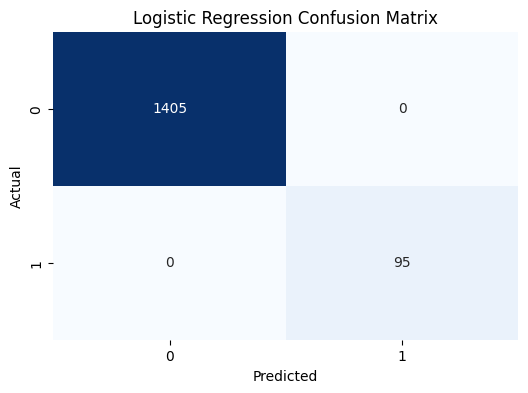


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1405
           1       1.00      1.00      1.00        95

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


# --- Evaluate Logistic Regression ---
print("---- Logistic Regression Evaluation ----")

# Predictions for Logistic Regression
y_pred_lr = log_reg.predict(X_test)

# Accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Test Accuracy: {accuracy_lr:.4f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))


## Random Forest
![Alt Text](https://lh7-rt.googleusercontent.com/docsz/AD_4nXe3JNfUwUxsnnGGaKBnN_S3RbjlQ8fhax-5vdOcHgJAPKwKlkjh1C2FgG7qcKoTPgEqjZw3pOHLRsXN_Gg-5tG__v0-7QgoFU-PXLyRXkhsQW7mUXZGZUPqlWpxxNa4EXbmN5yTRpqkXHaEaxWc0lM8M4LA?key=KLgTTR-x9BHpVAJjGeWAZw)


Random Forest is an ensemble method that uses multiple decision trees to classify data. It often performs well on a variety of datasets, including network traffic data.


In this cell, I am training and evaluating a **Random Forest Classifier** using the `scikit-learn` library.

### 1. Model Training:
We initialize the Random Forest model:

$RF(X) = \frac{1}{T} \sum_{t=1}^{T} h_t(X)$

Where:
- $RF(X)$ is the final prediction from the random forest.
- $T$ is the number of trees (in this case, $T=100$).
- $h_t(X)$ is the prediction from the $t$-th tree in the forest.
  
Each tree is built by selecting random subsets of features and samples, ensuring diversity in the ensemble. This approach helps in reducing overfitting and increases generalization.

The model learns by aggregating predictions from multiple decision trees using a majority vote (for classification).

### 2. Predictions:
We use the trained model to predict the labels for the test data (`X_test`) based on the majority vote of all decision trees in the forest.

### 3. Evaluation:
- **Accuracy**: The proportion of correctly predicted labels is calculated as:

$\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Predictions}} = \frac{\sum_{i=1}^{n} \mathbb{1}(\hat{y_i} = y_i)}{n}$

Where $n$ is the number of samples in the test set, $\hat{y_i}$ is the predicted label, and $y_i$ is the true label.

- **Classification Report**: This includes key metrics such as:
  - **Precision**: The proportion of true positive predictions among all positive predictions.
  - **Recall (Sensitivity)**: The proportion of true positives correctly identified.
  - **F1-score**: The harmonic mean of precision and recall.
  
These metrics provide a detailed view of the model's classification performance.


In [24]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1405
           1       1.00      1.00      1.00        95

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



---- Random Forest Evaluation ----
Random Forest Test Accuracy: 1.0000


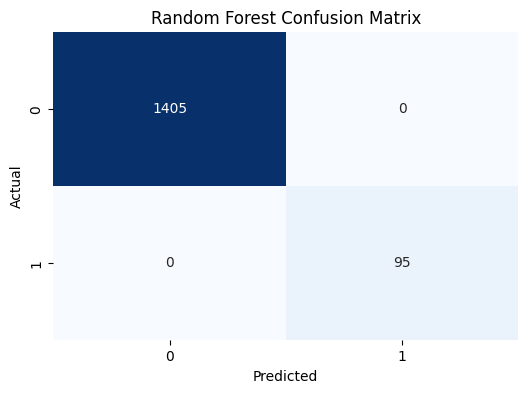


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1405
           1       1.00      1.00      1.00        95

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



In [25]:
# --- Evaluate Random Forest ---
print("---- Random Forest Evaluation ----")

# Predictions for Random Forest
y_pred_rf = rf_model.predict(X_test)

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Test Accuracy: {accuracy_rf:.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


## Neural Network
![Alt Text](https://www.spotfire.com/content/dam/spotfire/images/graphics/inforgraphics/neutral-network-diagram.svg)
A Neural Network model can learn complex patterns in the data. We'll use a simple feed-forward neural network for this classification task.


In this cell, I am building, training, and evaluating a **Neural Network model** using the `TensorFlow` and `Keras` libraries.

### 1. Building the Neural Network:
We use the `Sequential` model, which allows us to build a neural network layer by layer.

- **Input Layer**:
  - The input layer has 64 neurons and takes an input dimension of $X_{\text{train}}.shape[1]$, which corresponds to the number of features in the dataset.
  - Activation function: **ReLU** (Rectified Linear Unit), defined as:
  
  $f(x) = \max(0, x)$
  
  ReLU introduces non-linearity into the model.

- **Hidden Layers**:
  - The first hidden layer has 32 neurons and also uses the ReLU activation.
  - A **Dropout** layer with a rate of 0.2 is added to reduce overfitting by randomly turning off 20% of the neurons during training.
  - The second hidden layer has 16 neurons, again using ReLU activation.

- **Output Layer**:
  - The output layer has 1 neuron, as we are performing binary classification.
  - Activation function: **Sigmoid**, which outputs a probability between 0 and 1:

  $\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}$

### 2. Compilation:
The model is compiled using:
- **Loss function**: **Binary Crossentropy** for binary classification tasks. It is defined as:

  $\mathcal{L} = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i}) \right]$

  where $y_i$ is the true label and $\hat{y_i}$ is the predicted probability.
  
- **Optimizer**: **Adam** (Adaptive Moment Estimation), an efficient gradient-based optimization algorithm.
- **Metrics**: We track **accuracy** during training.

### 3. Model Training:
The model is trained on the training data (`X_train`, `y_train`) for 10 epochs with a batch size of 32. We also use 20% of the training data for validation (`validation_split=0.2`) to monitor the model's performance on unseen data during training.

### 4. Model Evaluation:
The model is evaluated on the test set (`X_test`, `y_test`), and the **test accuracy** is computed and printed. The accuracy is the proportion of correct predictions:

$\text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Predictions}}$


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Building the neural network
model = Sequential()

# Input layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))

# Hidden layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Neural Network Test Accuracy: {test_accuracy:.4f}')


Epoch 1/10


c:\Users\Achref\Desktop\Engineering\IEEE-EniCarthageSB\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8738 - loss: 0.3454 - val_accuracy: 1.0000 - val_loss: 0.0029
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 5.8637e-04
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0038 - val_accuracy: 1.0000 - val_loss: 2.5616e-04
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 1.4656e-04
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9998 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 8.6603e-05
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9999 - loss: 9.3244e-04 - val_accuracy: 1.0000 - val_loss: 4.4678e-05
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 6.3660e-04 - val_accuracy: 1.0000 - val_loss: 3.4251e-05
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.00

## Evaluating the Model

After training the model, it's important to evaluate its performance on the test set to see how well it generalizes to unseen data.


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 5.2015e-06
Test Accuracy: 1.0000


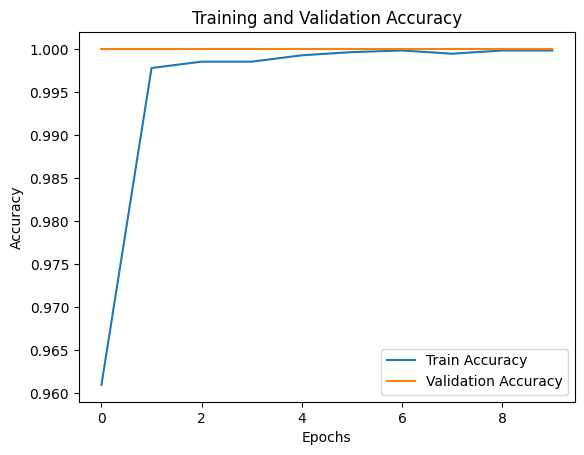

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


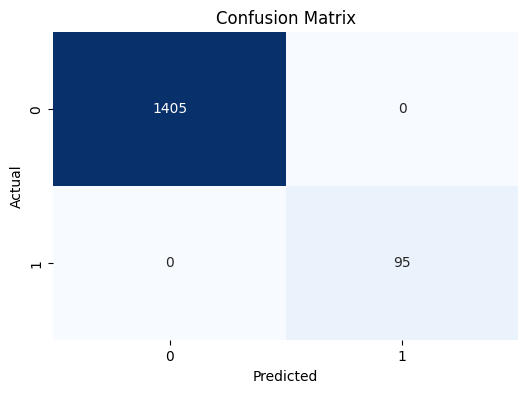


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1405
           1       1.00      1.00      1.00        95

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500



In [34]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plotting the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))
